In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



In [2]:
df_europapark = pd.read_parquet("../data/processed/ep/merged_data.parquet")
df_rulantica = pd.read_parquet("../data/processed/rulantica/merged_data.parquet")
df_europapark

,ride_name,timestamp,wait_time,closed,temperature,rain,wind
0,alpine express enzian,2017-05-23 09:00:00,1.0,False,18.7,0.0,1.1
1,poppy towers,2017-05-23 09:00:00,0.0,False,18.7,0.0,1.1
2,silver star,2017-05-23 09:00:00,0.0,False,18.7,0.0,1.1
3,swiss bob run,2017-05-23 09:00:00,1.0,False,18.7,0.0,1.1
4,tirol log flume,2017-05-23 09:00:00,1.0,False,18.7,0.0,1.1
...,...,...,...,...,...,...,...
14196898,fjordrafting,2024-12-31 21:00:00,0.0,True,NaN,NaN,NaN
14196899,jim button journey through morrowland,2024-12-31 21:00:00,0.0,True,NaN,NaN,NaN
14196900,josefinas magical imperial journey,2024-12-31 21:00:00,0.0,True,NaN,NaN,NaN
14196901,madame freudenreich curiosits,2024-12-31 21:00:00,0.0,True,NaN,NaN,NaN


# Basic Information

In [3]:
df_europapark["ride_name"].nunique()

35

In [4]:
empty_count = df_europapark['wait_time'].isna().sum()
print("Total Wait Time empty_count: " +  str(empty_count))
print("Total Wait Time empty_percentage: " +  str(len(df_europapark)/empty_count))


# For now I'm dropping the empty Values but we will discuss on what to do with them. Probably fill with the mean based on ride, hour and season.
df_europapark.dropna(subset=['wait_time'], inplace=True)

Total Wait Time empty_count: 1929048
Total Wait Time empty_percentage: 7.35953848737823


# Wait Time Distribution

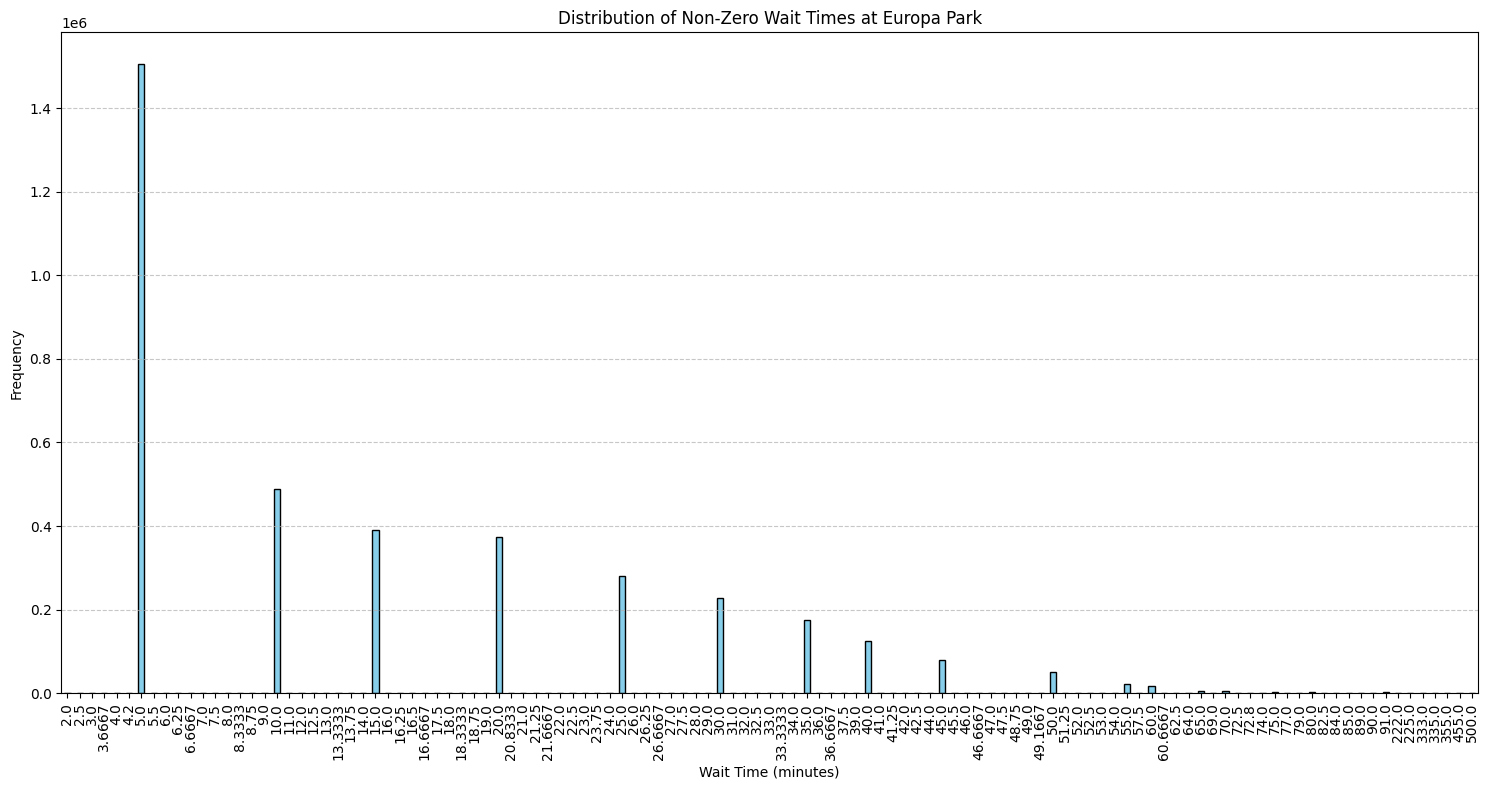

Total non-zero wait time entries: 3757491
Number of unique wait times: 115
Most common wait time: 5.0 minutes (frequency: 1505977)
Longest wait time: 500.0 minutes


In [5]:
#without 0 because there are too many
wait_time_counts = df_europapark[df_europapark["wait_time"] > 1]["wait_time"].value_counts().sort_index()

plt.figure(figsize=(15, 8))
wait_time_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Distribution of Non-Zero Wait Times at Europa Park')
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

print(f"Total non-zero wait time entries: {wait_time_counts.sum()}")
print(f"Number of unique wait times: {len(wait_time_counts)}")
print(f"Most common wait time: {wait_time_counts.idxmax()} minutes (frequency: {wait_time_counts.max()})")
print(f"Longest wait time: {wait_time_counts.index.max()} minutes")

In [6]:
wait_time_counts = df_europapark[df_europapark["wait_time"] > 1]["wait_time"].value_counts().sort_index()
non_divisible_by_5 = sum(count for wait_time, count in wait_time_counts.items() if wait_time % 5 != 0)

total = wait_time_counts.sum()
percentage = (non_divisible_by_5 / total) * 100

print(f"Entries not divisible by 5: {non_divisible_by_5}")
print(f"Percentage of total: {percentage:.2f}%")


Entries not divisible by 5: 3516
Percentage of total: 0.09%


Therefore we can probably clip those 0.09% to the next number which is dividable by 5

Entries not divisible by 5 after rounding: 0
Percentage of total after rounding: 0.00%


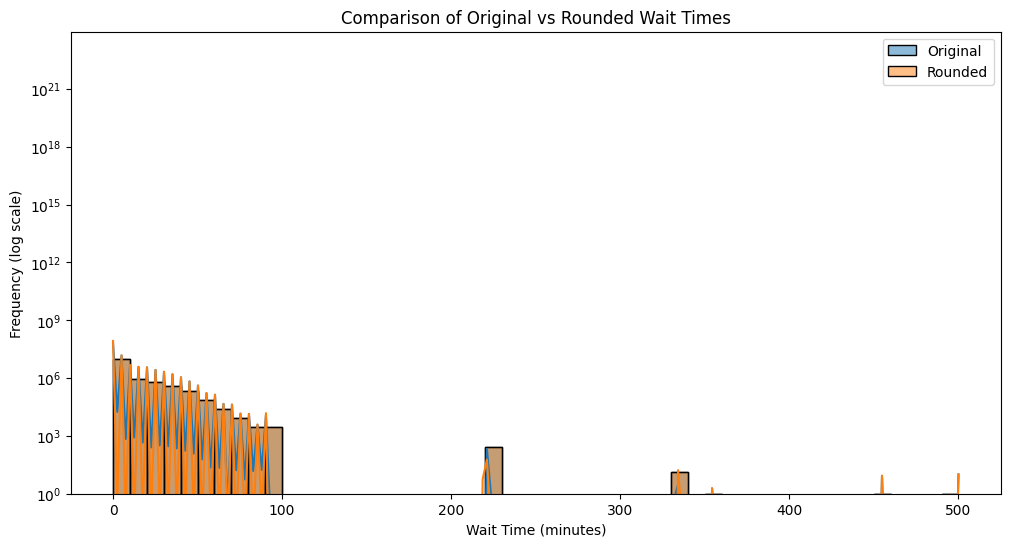

In [ ]:
def round_to_nearest_5(x):
    return 5 * round(x/5)

df_europapark['wait_time_rounded'] = df_europapark['wait_time'].apply(round_to_nearest_5)

wait_time_counts_rounded = df_europapark[df_europapark["wait_time_rounded"] > 1]["wait_time_rounded"].value_counts().sort_index()
non_divisible_by_5 = sum(count for wait_time, count in wait_time_counts_rounded.items() if wait_time % 5 != 0)

total_rounded = wait_time_counts_rounded.sum()
percentage_rounded = (non_divisible_by_5 / total_rounded) * 100

print(f"Entries not divisible by 5 after rounding: {non_divisible_by_5}")
print(f"Percentage of total after rounding: {percentage_rounded:.2f}%")

plt.figure(figsize=(12, 6))
sns.histplot(df_europapark['wait_time'], kde=True, label='Original', alpha=0.5, bins=50)
sns.histplot(df_europapark['wait_time_rounded'], kde=True, label='Rounded', alpha=0.5, bins=50)
plt.title('Comparison of Original vs Rounded Wait Times')
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')
plt.ylim(bottom=1) 
plt.legend()

plt.show()


In [22]:
df_europapark["wait_time_rounded"].value_counts().sort_index()

wait_time_rounded
0      8510665
5      1506334
10      489455
15      390667
20      373179
25      280317
30      227959
35      175115
40      125377
45       78849
50       49752
55       21032
60       18165
65        6409
70        6211
75        2237
80        2292
85         697
90        2866
220        259
225          1
335         14
355          1
455          1
500          1
Name: count, dtype: int64

# Average Waiting Time

/tmp/ipykernel_261771/84895637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_europapark_filtered['hour'] = df_europapark_filtered['timestamp'].dt.hour


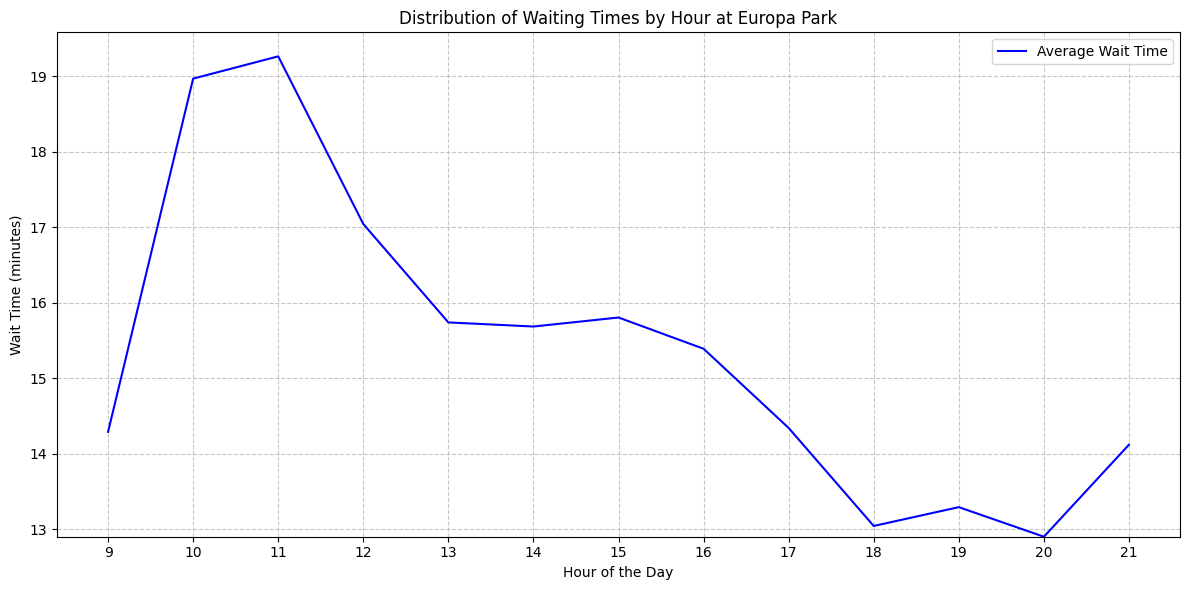

In [23]:
df_europapark_filtered = df_europapark[df_europapark["wait_time_rounded"] > 1]
df_europapark_filtered['hour'] = df_europapark_filtered['timestamp'].dt.hour
daily_wait_times = df_europapark_filtered.groupby('hour')['wait_time_rounded'].agg(['max', 'min', 'mean'])

first_hour = daily_wait_times.index.min()
last_hour = daily_wait_times.index.max()

min_wait_time = daily_wait_times['mean'].min()

plt.figure(figsize=(12, 6))
plt.plot(daily_wait_times.index, daily_wait_times['mean'], label='Average Wait Time', color='blue')

plt.title('Distribution of Waiting Times by Hour at Europa Park')
plt.xlabel('Hour of the Day')
plt.ylabel('Wait Time (minutes)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(first_hour, last_hour + 1))
plt.ylim(bottom=min_wait_time)
plt.tight_layout()
plt.show()



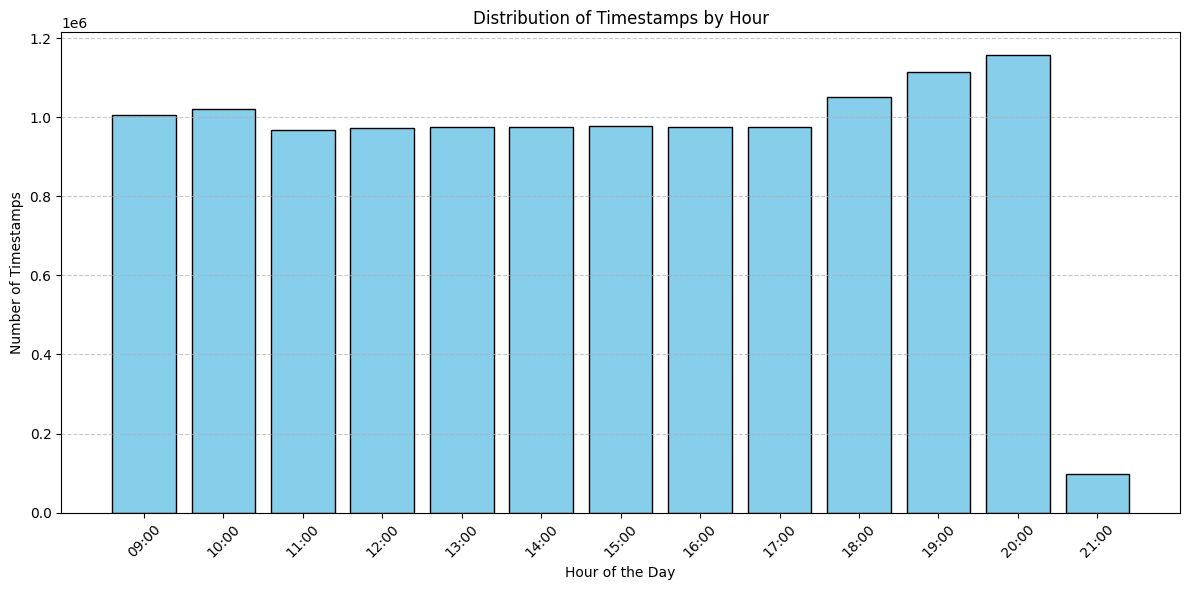

Hourly Distribution:
9     1005328
10    1020607
11     968999
12     973858
13     975553
14     975843
15     977615
16     975311
17     975862
18    1051056
19    1113643
20    1157044
21      97136
dtype: int64


In [9]:
df_europapark['hour'] = df_europapark['timestamp'].dt.hour

hourly_distribution = df_europapark['hour'].value_counts().sort_index()

full_hour_range = pd.Series(0, index=range(9, 22)) 
hourly_distribution = full_hour_range.add(hourly_distribution, fill_value=0).astype(int) 

hours_list = hourly_distribution.index.tolist()

plt.figure(figsize=(12, 6))
plt.bar(hours_list, hourly_distribution, color='skyblue', edgecolor='black')

plt.title('Distribution of Timestamps by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Timestamps')

plt.xticks(ticks=hours_list, labels=[f"{h:02d}:00" for h in hours_list], rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Hourly Distribution:")
print(hourly_distribution)


<Figure size 1200x600 with 0 Axes>

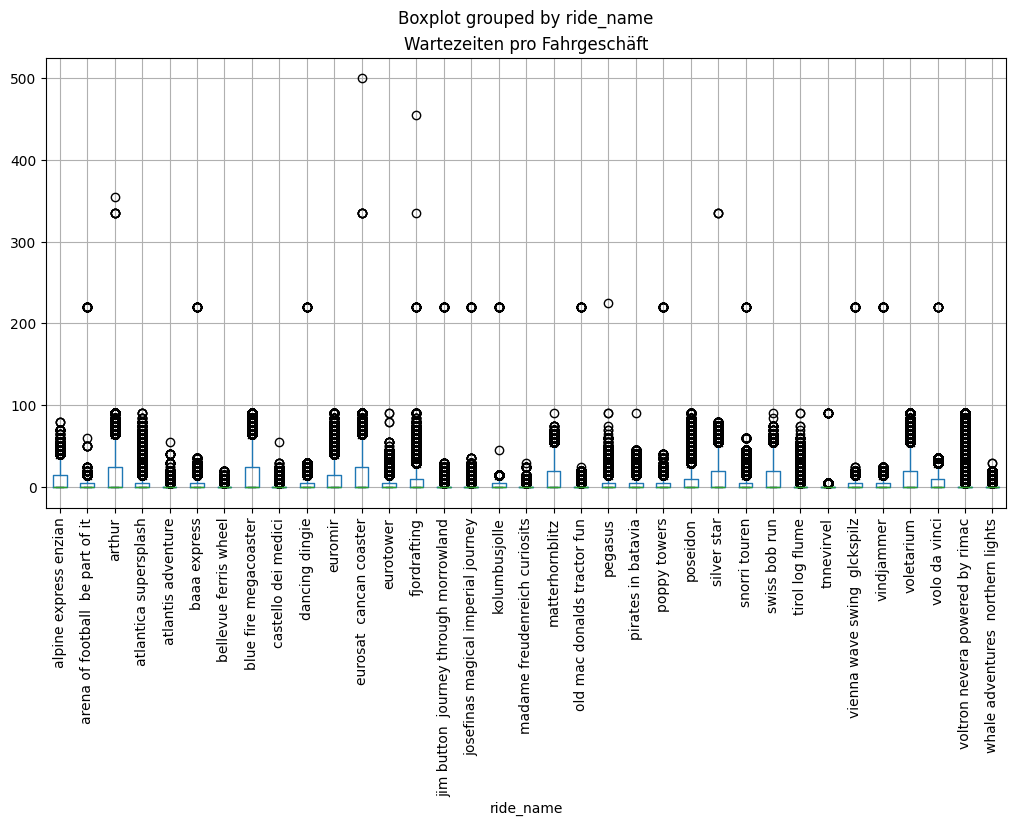

In [24]:
plt.figure(figsize=(12, 6))
df_europapark.boxplot(column='wait_time_rounded', by='ride_name', figsize=(12, 6))
plt.title('Wartezeiten pro Fahrgeschäft')
plt.xticks(rotation=90)
plt.show()


There are some outliers but those between 200 and 300 seem to be systematic so we'll dive deeper into that

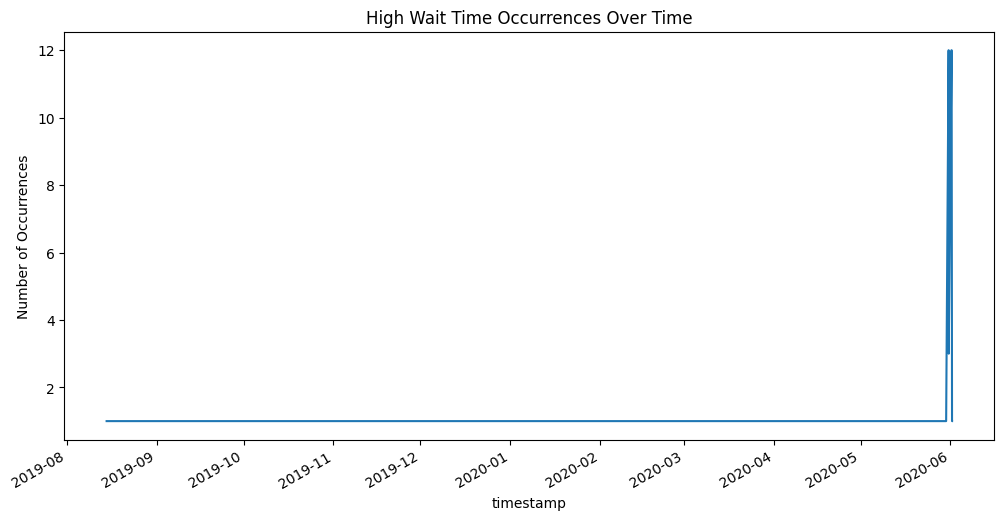

/tmp/ipykernel_261771/1531742521.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_times_200_300['date'] = df_times_200_300['timestamp'].dt.date


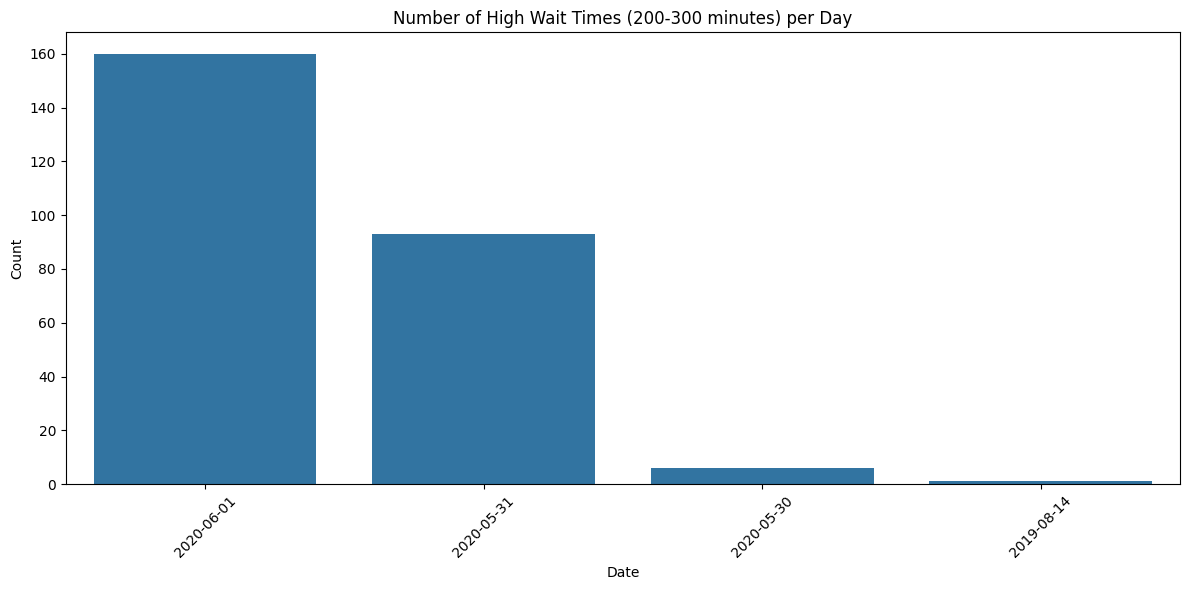

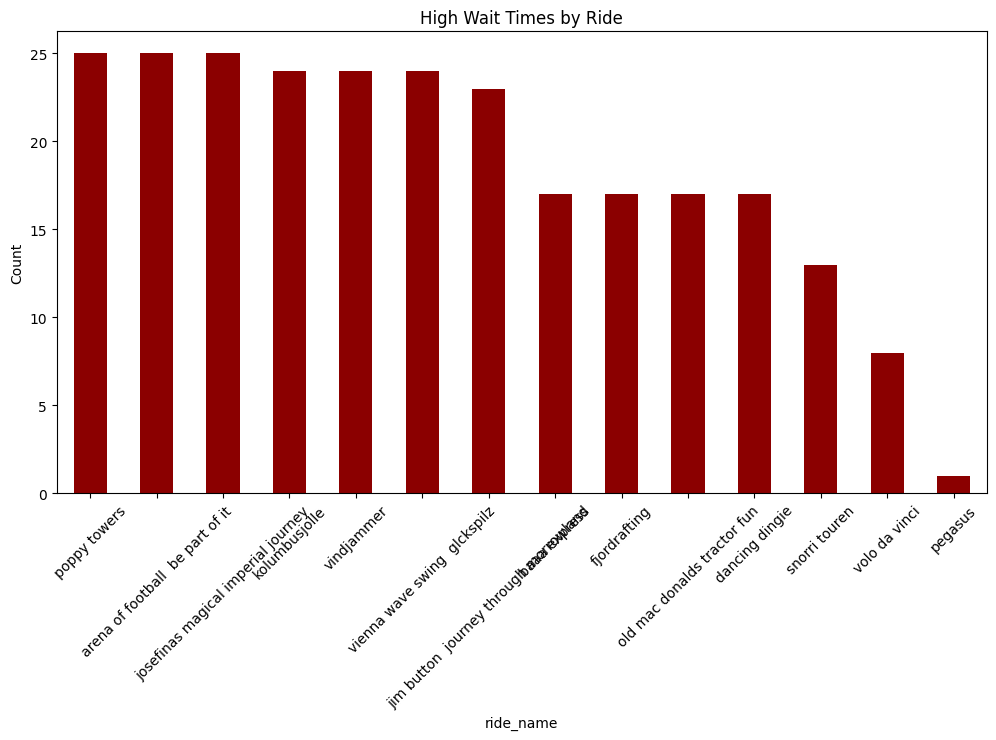

In [25]:
df_times_200_300 = df_europapark[(df_europapark['wait_time_rounded'] >= 200) & (df_europapark['wait_time_rounded'] <= 300)]

# 1. Temporal Distribution
plt.figure(figsize=(12, 6))
df_times_200_300.groupby('timestamp').size().plot(title='High Wait Time Occurrences Over Time')
plt.ylabel('Number of Occurrences')
plt.show()

# 2 Day Specific . 
df_times_200_300['date'] = df_times_200_300['timestamp'].dt.date
daily_counts = df_times_200_300.groupby('date').size().reset_index(name='count')

daily_counts = daily_counts.sort_values('count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='date', y='count', data=daily_counts)
plt.title('Number of High Wait Times (200-300 minutes) per Day')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Ride-Specific Aalysis
plt.figure(figsize=(12, 6))
df_times_200_300['ride_name'].value_counts().plot(kind='bar', color='darkred')
plt.title('High Wait Times by Ride')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()




2020-05-30 until 2020-06-01 seems to be a irregularity and can probably be removed. Due to this being covid we should check the entire timespan of covid on how much it differs from the average

# Boxplots without outliers

Total rows: 12267855
Rows after filtering: 12267578
Rows lost: 277
Percentage of data lost: 0.00%


<Figure size 1200x600 with 0 Axes>

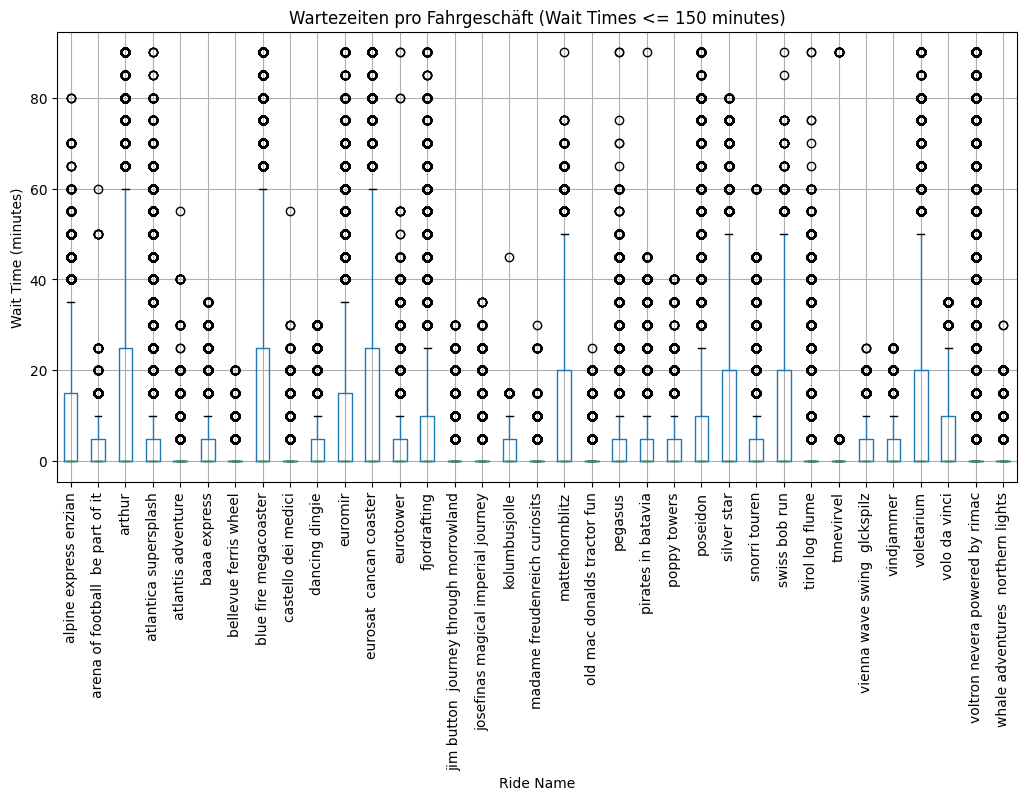

In [26]:

df_filtered = df_europapark[df_europapark['wait_time_rounded'] <= 150]

total_rows = len(df_europapark)
filtered_rows = len(df_filtered)
lost_rows = total_rows - filtered_rows
percentage_lost = (lost_rows / total_rows) * 100

print(f"Total rows: {total_rows}")
print(f"Rows after filtering: {filtered_rows}")
print(f"Rows lost: {lost_rows}")
print(f"Percentage of data lost: {percentage_lost:.2f}%")

# Create the box plot
plt.figure(figsize=(12, 6))
df_filtered.boxplot(column='wait_time_rounded', by='ride_name', figsize=(12, 6))
plt.title('Wartezeiten pro Fahrgeschäft (Wait Times <= 150 minutes)')
plt.suptitle('') 
plt.xticks(rotation=90)
plt.xlabel('Ride Name')
plt.ylabel('Wait Time (minutes)')
plt.show()


In [13]:
df_europapark['date'] = df_europapark['timestamp'].dt.date
opening_closing_times = df_europapark.groupby('date')['timestamp'].agg(['min', 'max'])
opening_closing_times

,min,max
date,,
2017-05-23,2017-05-23 09:00:00,2017-05-23 21:00:00
2017-05-24,2017-05-24 09:00:00,2017-05-24 21:00:00
2017-05-25,2017-05-25 09:00:00,2017-05-25 21:00:00
2017-05-26,2017-05-26 09:00:00,2017-05-26 21:00:00
2017-05-27,2017-05-27 09:00:00,2017-05-27 21:00:00
...,...,...
2024-12-27,2024-12-27 09:00:00,2024-12-27 21:00:00
2024-12-28,2024-12-28 09:00:00,2024-12-28 21:00:00
2024-12-29,2024-12-29 09:00:00,2024-12-29 21:00:00


# Covid

Comparison of Wait Times:
                       count       mean   50%    max
COVID Period        367667.0  14.562471  10.0  335.0
Normal Operations  3389523.0  16.300763  10.0  500.0


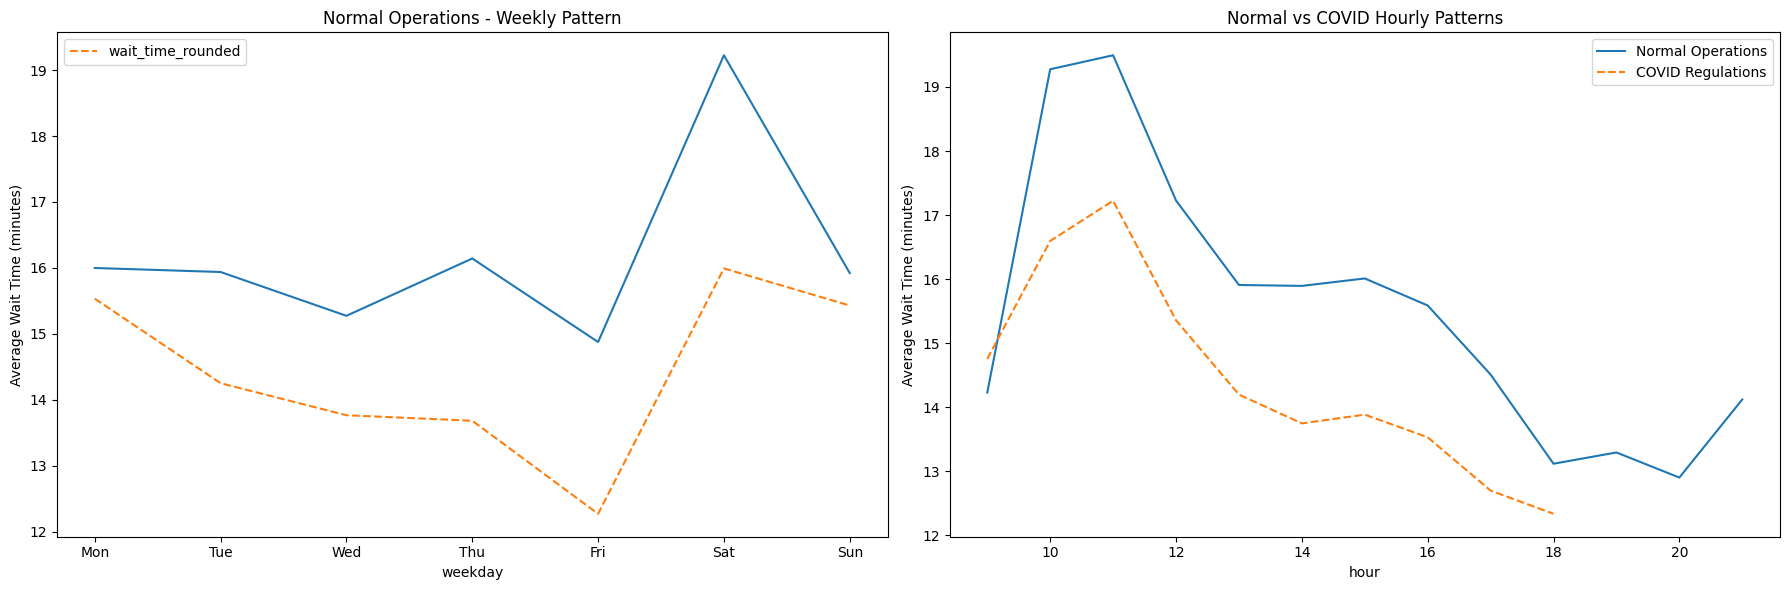

In [31]:

covid_start = '2020-03-16'
covid_end = '2021-06-30'


df_filtered = df_europapark[df_europapark["wait_time_rounded"] >= 4].copy()
df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])
df_filtered['weekday'] = df_filtered['timestamp'].dt.weekday
df_filtered['hour'] = df_filtered['timestamp'].dt.hour

covid_mask = (df_filtered['timestamp'] >= covid_start) & (df_filtered['timestamp'] <= covid_end)

df_covid = df_filtered[covid_mask]
df_normal = df_filtered[~covid_mask]


covid_stats = df_covid['wait_time_rounded'].describe()
normal_stats = df_normal['wait_time_rounded'].describe()

comparison = pd.DataFrame({
    'COVID Period': covid_stats,
    'Normal Operations': normal_stats
}).T[['count', 'mean', '50%', 'max']]

print("Comparison of Wait Times:")
print(comparison)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Weekday analysis
pd.pivot_table(df_normal, index='weekday', values='wait_time_rounded', aggfunc='mean').plot(
    ax=ax[0], title='Normal Operations - Weekly Pattern', legend=False)
pd.pivot_table(df_covid, index='weekday', values='wait_time_rounded', aggfunc='mean').plot(
    ax=ax[0], linestyle='--')
ax[0].set_xticks(range(7))
ax[0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax[0].set_ylabel('Average Wait Time (minutes)')

# Hourly analysis
pd.pivot_table(df_normal, index='hour', values='wait_time_rounded', aggfunc='mean').plot(
    ax=ax[1], title='Normal vs COVID Hourly Patterns')
pd.pivot_table(df_covid, index='hour', values='wait_time_rounded', aggfunc='mean').plot(
    ax=ax[1], linestyle='--')
ax[1].legend(['Normal Operations', 'COVID Regulations'])
ax[1].set_ylabel('Average Wait Time (minutes)')

plt.tight_layout()
plt.show()


In [28]:
df_covid["wait_time_rounded"].value_counts().sort_index()

wait_time_rounded
5      164710
10      46926
15      38813
20      35375
25      25361
30      20302
35      14462
40      10566
45       5796
50       3125
55        804
60        731
65        107
70         83
75         14
80         14
85         44
90        162
220       259
335        13
Name: count, dtype: int64

In [29]:
df_normal["wait_time_rounded"].value_counts().sort_index()

wait_time_rounded
5      1341624
10      442529
15      351854
20      337804
25      254956
30      207657
35      160653
40      114811
45       73053
50       46627
55       20228
60       17434
65        6302
70        6128
75        2223
80        2278
85         653
90        2704
225          1
335          1
355          1
455          1
500          1
Name: count, dtype: int64